# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### 1.1


In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

290584 unique users

**d.** The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
len(df.query('group == "treatment" and landing_page =="old_page"'))+len(df.query('group == "control" and landing_page =="new_page"'))

3893

**f.** Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values 

### 1.2  


In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df1=df.drop(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index)

In [10]:
df2=df1.drop(df1[(df1['group'] == 'treatment') & (df1['landing_page'] == 'old_page')].index)

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2.shape

(290585, 5)

### 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [13]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

290584 unique user

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [15]:
df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [16]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

# Check again if the row with a duplicate user_id is deleted or not
df2.drop_duplicates(['user_id'],keep='first',inplace=True)

In [17]:
df2.shape

(290584, 5)

### 1.4  
**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [18]:
P_pop=df2.converted.mean()
P_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [21]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=df2.query('group == "treatment"')['converted'].mean()-df2.query('group == "control"')['converted'].mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [22]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>  The Conversion rate = -0.00157  which there is no sufficient evidence that the new page or the new treatment group have a higher conversion rate than the old one or the Control group .

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


###  2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

> **Null hypotheses( H0 : $p_{old}$ >= $p_{new}$ )  ,  Alternative hypotheses( H1 : $p_{new}$ > $p_{old}$**)

###  2.2 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [23]:
# In the null hypothesis , P_new = P_old = P_pop (converted rate)
P_new = df2['converted'].mean()
P_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [24]:
# In the null hypothesis , P_new = P_old = P_pop (converted rate)
P_old = df2['converted'].mean()
P_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [25]:
n_new=len(df2.query('group == "treatment"'))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old=len(df2.query('group == "control"'))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [27]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=n_new, p=[P_new, 1-P_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [28]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=n_old, p=[P_old, 1-P_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.0020460386045397655


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted_mean = np.random.choice([1, 0], size=n_new, p=[P_new, 1-P_new]).mean()
    old_page_converted_mean = np.random.choice([1, 0], size=n_old, p=[P_old, 1-P_old]).mean()
    p_diffs.append(new_page_converted_mean - old_page_converted_mean)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


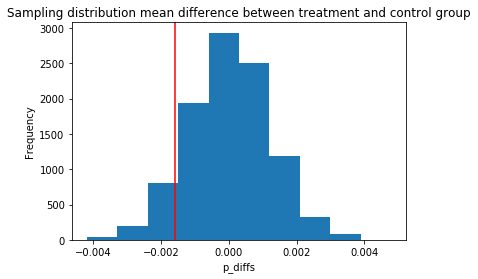

In [31]:
# convert to numby array
p_diffs = np.array(p_diffs)
# plot the array to histogram 
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Sampling distribution mean difference between treatment and control group');
plt.axvline(x=obs_diff, color='r');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [32]:
( p_diffs > obs_diff).mean()

0.9074

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**It's called P-value which equal 0.907 . this value is large enough to not reject the null hypothesis . so there is no evidence that the new page has a heigher conversion rate than the old one**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('group == "control" & converted == 1'))

# number of conversions with the new_page
convert_new =len(df2.query('group == "treatment" & converted == 1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('group == "control"'))

# number of individuals who received new_page
n_new = len(df2.query('group == "treatment"'))

convert_old , convert_new , n_old ,  n_new

(17489, 17264, 145274, 145310)

In [34]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old],alternative='larger',prop_var=False)
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



>**$Z_{score}$(-1.310) < $Z_{\alpha}$. in right-tailed test , so we can't reject null hypothesis . p_value=0.905 is large enough (>0.05) to not reject null  hypothesis**

<a id='regression'></a>
### Part III - A regression approach

###  3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**logistic regression , as there are only two values (conversion or no conversion).**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
#getting the dummy columns
df2[['control','treatment']] = pd.get_dummies(df2['group'])
#drop this column
df2 = df2.drop('control', axis=1)
# rename treatment to ab_page
df2.rename(columns={'treatment': 'ab_page'},inplace=True)
df2['intercept'] = 1
df2.head()


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
#fitting the result
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
# display the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:               8.077e-06
Time:                        09:33:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



>**p-value associated with ab_page = 0.190  > Type_I error (0.05) , so no evidence to reject the null hypotheses. the P-value here in part III differs from P-value in part II as the null and Alternative hypotheses are different in both cases . In this case (part III) the  hypotheses is two-tailed which has the alternative : "the new page has a different conversion rate than the old page" . however In type II , it's one-tailed and the alternative : "the new page has a greater conversion rate than the old page"**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It is a good idea to consider other factors to add into your regression model . The disadvantage : there are a number of problems that may arise such as : complexity , the multiple comparison problem ( that may lead to erroneous inferences due to The more inferences added) and the Multicollinearity ( when we have predictor variables that are correlated with one another. it can lead to coefficients being flipped from the direction we expect)**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
 

 Provide the statistical output as well as a written response to answer this question.

In [39]:
# Read the countries.csv
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
# Join countries with the df2 dataframe
df2_countries = countries_df.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
df2_countries.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
# get the unique values of country
df2_countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
# Create the necessary dummy variables
df2_countries[['UK', 'US', 'CA']] = pd.get_dummies(df2_countries['country'])
df2_countries.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [43]:
#adding the new columns
df2_countries['US_ab_page'] = df2_countries['US']*df2_countries['ab_page']
df2_countries['UK_ab_page'] = df2_countries['UK']*df2_countries['ab_page']

In [44]:
df2_countries.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [45]:
# Fit the model, and summarize the results
logit_mod = sm.Logit(df2_countries['converted'],df2_countries[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:               3.482e-05
Time:                        09:37:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

>**The p_value for both interaction terms is greater than 0.05. there is no evidence in both cases to reject null hypotheses. the interaction between country and page is not sufficient and there is no influence diffrence in case of adding  US or Ca .
So the country has no impact on conversion**

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0